# Exercises on Feature Engineering Basics in R
* Author: Oliver Kretzschmar
* Last Update: 2019-11-17

## Solve the tasks ...

Your solution should contain 
* the implemented code in code-cells, 
* the output of this code 
* and optionally your remarks, discussion, comments on the solution in markdown-cells.

Send me the resulting Jupyter notebook.

## Tasks


In [288]:
library(tidyverse)
library(data.table)
library(car)


library(modelr)

library(reshape)  #Calculate Pivot table
library(rsample)  #For splitting - see https://tidymodels.github.io/recipes/articles/Simple_Example.html
library(recipes)  #For data recipes - see https://tidymodels.github.io/recipes/

#install.packages("stringr")
library(stringr) #We use stringr package for better string operations - see https://r4ds.had.co.nz/strings.html#introduction-8 

library(moments) #Skewness function ...
library(dbscan) #DBSCAN

#install.packages("gridExtra")
library(gridExtra) #Arrange more ggplots on canvas


library(corrplot) #Scatterplots

library(caret) #Model functions
# install.packages('Boruta')
library(Boruta) #For Feature functions


1. Implement a convenient function 'handleOutlier(data, ...)' to handle outliers by the Interquartile Range (IQR) method for dropping or imputation in a FE process for a complete data frame 'data'. Implement it by hand.


In [289]:
#create sample mini dataset
salary1 <- c(123, 123, 123, 123, 123, 123, 123, 123)
salary2 <- c(123, 123, 124, 124, 124, 124, 215, 125)
salary3 <- c(234155, 23412, 5678, 5678, 456, 23400, 345, 23400)
salary4 <- c(456, 676, 456, 786, 786, 459, 7899, 166)
salary5 <- c(456, 123, 22300, 90, 23400, 23400, 5678, 9999999)
salary6 <- c("abc", "abc", "abc", "abc", "abc", "abc", "abc", "abcd")



employ.data <- data.frame(salary1, salary2, salary3, salary4, salary5, salary6)
employ.data

salary1,salary2,salary3,salary4,salary5,salary6
123,123,234155,456,456,abc
123,123,23412,676,123,abc
123,124,5678,456,22300,abc
123,124,5678,786,90,abc
123,124,456,786,23400,abc
123,124,23400,459,23400,abc
123,215,345,7899,5678,abc
123,125,23400,166,9999999,abcd


In [290]:
findOutlier <-function (column){
    outliner <- NULL
    if (is.numeric(column)){
        BoxLow <- quantile(column, probs = c(0.25))
        BoxUp <- quantile(column, probs = c(0.75))
        #cat("BoxLow: ", BoxLow,"\n")
        #cat("BoxUp: ", BoxUp,"\n")
        #get indexes
        outliner <- which(column > BoxUp | column < BoxLow)
        }
    #fill with zeros so every column has same length and can be converted to df
    while (length(column) > length(outliner)){
        outliner <- c(outliner, 0)
    }
    #print(outliner)
    return (outliner)
        
}

handleOutlier <- function(data, mode){
    data <- na.omit(data)
    #get outliner per Column
    pos <- lapply(data, findOutlier)
    #convert resulting list to DF
    pos <-data.frame(do.call(rbind.data.frame, pos))
    if(mode=="dropping"){
        #get unique values of pos dataframe
        columnids=c()
        
        for(i in 1:ncol(pos)){
          columnids=c(unique(pos[,i]), columnids)
          columnidsunique=unique(columnids)
        }
        
        #drop data
        cleanData <- data[,-columnidsunique]
        return (cleanData)
    }
    
    else if (mode=="imputation"){
        #impute with median
        #get colmeans        
        #seems lapply doesnt work here because we have to access child of childs
        colmeans <- NULL
        for(i in 1:ncol(data)){
            if (is.numeric(data[[i]])){
                colmeans <- c(colmeans, median(data[[i]]))
            }
            else{
                 colmeans <- c(colmeans, NA)
            }
        }
        for(i in 1:ncol(pos)){
            for (j in 1:nrow(pos)){
                if (pos[j,i]==0 || j ==0){
                    next
                }
                data[pos[j,i], j] = colmeans[j]
            }
        }
        return (data)
    }
}






In [291]:
#test funtion
handleOutlier(employ.data,"imputation")

salary1,salary2,salary3,salary4,salary5,salary6
123,124,14539,456.0,456,abc
123,124,14539,676.0,13989,abc
123,124,5678,456.0,22300,abc
123,124,5678,786.0,13989,abc
123,124,14539,786.0,23400,abc
123,124,23400,459.0,23400,abc
123,124,14539,567.5,5678,abc
123,124,23400,567.5,13989,abcd


2. Implement a convenient function 'handleCollinearity(data, ...)' to check and correct multicollinearity in a FE process for a complete data frame 'data'. Implement it by hand, but use the functions 'vif()' and 'alias()' as described in the main Feature Engineering lecture.


In [292]:
removelastchar <- function(text){
         val <- substr(text, 1, nchar(text)-1)  
}

In [293]:
handleCollinearity <- function(mydata, label){
    
    datacolnames <-colnames(mydata)
    datacolnames = datacolnames[datacolnames != label]

    f <- as.formula(paste(label, 
        paste(datacolnames, collapse = " + "), 
        sep = " ~ "))
    lm.fitMult<-lm(f, mydata)
    #get linearly dependent variables
    ld.vars <- attributes(alias(lm.fitMult)$Complete)$dimnames[[1]]

    #remove weird ones to get original names
    ld.vars <- lapply(ld.vars, removelastchar)
    #remove linearly dependent  variables from datacolnames and make new formular
    datacolnames = datacolnames[!datacolnames %in% ld.vars]
    f <- as.formula(paste(label, 
        paste(datacolnames, collapse = " + "), 
        sep = " ~ "))
    #run model again with out aliases
    lm.fitMult<-lm(f, mydata)
    
    #Calculate the VIFs
    vifs <- vif(lm.fitMult)
    if (max(vifs) > 5 && ncol(mydata)>1){
        #get max vif col name and drop col
        maxColumnName <-names(which.max(vifs))
        var.out.bool <- !names(mydata) %in% maxColumnName
        #simply reassign data:
        mydata <- mydata[,var.out.bool, drop = FALSE]
        #rekursive call
        handleCollinearity(mydata, label)
    }
    else{ 
        return(mydata)
    }
}

In [294]:
#test funtion
handleCollinearity(employ.data, "salary1")

Warning message in summary.lm(object, ...):
"essentially perfect fit: summary may be unreliable"Warning message in summary.lm(object, ...):
"essentially perfect fit: summary may be unreliable"Warning message in summary.lm(object, ...):
"essentially perfect fit: summary may be unreliable"

salary1,salary2,salary3,salary6
123,123,234155,abc
123,123,23412,abc
123,124,5678,abc
123,124,5678,abc
123,124,456,abc
123,124,23400,abc
123,215,345,abc
123,125,23400,abcd


3. Read data from [LeadUserData1_untidy.csv](../data/LeadUserData1_untidy.csv) and do a complete Feature Engineering process with imputation of missing values, handling outliers, data transformations, correct multicollinearity, correct imbalancing classes etc. Use mostly the "recipe" package as discussed in the lecture and your above implemented functions.


In [295]:
#dont drop missing values
options(na.action = na.warn)

data <- read.csv(file="../data/LeadUserData1_untidy.csv", header=TRUE,sep=",")
glimpse(data)
#hist(data$WorkaroundIntensity)
#data<-handleOutlier(data,"WorkaroundIntensity","NA")
#hist(data$WorkaroundIntensity)
#data<-handleCollinearity(data)

Observations: 2,103
Variables: 18
$ customerID          <fct> 3668-QPYBK, 9237-HQITU, 9305-CDSKC, 7892-POOKP,...
$ gender              <fct> Male, Female, Female, Female, Male, Female, Fem...
$ tenure              <int> 2, 2, 8, 28, 49, 69, 10, 1, 1, 47, 1, 17, 5, 46...
$ PhoneService        <fct> Yes, Yes, Yes, Yes, Yes, Yes, Yes, No, Yes, Yes...
$ MultipleProducts    <fct> No, No, Yes, Yes, Yes, Yes, No, No phone servic...
$ InternetService     <fct> DSL, Fiber optic, Fiber optic, Fiber optic, Fib...
$ OnlineSecurity      <fct> Yes, No, No, No, No, Yes, No, No, No internet s...
$ OnlineBackup        <fct> Yes, No, No, No, Yes, Yes, No, No, No internet ...
$ DeviceProtection    <fct> No, No, Yes, Yes, Yes, Yes, Yes, Yes, No intern...
$ TechSupport         <fct> No, No, No, Yes, No, Yes, Yes, No, No internet ...
$ UsingSocial         <fct> No, No, Yes, Yes, Yes, Yes, No, No, No internet...
$ SupportMovies       <fct> No, No, Yes, Yes, Yes, Yes, No, Yes, No interne...
$ TimeUsingProduct

In [296]:
summary(data)

      customerID      gender         tenure      PhoneService
 0004-TLHLJ:   1   Female:1045   Min.   : 1.00   No  : 188   
 0011-IGKFF:   1   Male  :1047   1st Qu.: 3.00   Yes :1904   
 0013-EXCHZ:   1   NA's  :  11   Median :13.00   NA's:  11   
 0013-SMEOE:   1                 Mean   :22.37               
 0022-TCJCI:   1                 3rd Qu.:40.00               
 (Other)   :2087                 Max.   :72.00               
 NA's      :  11                 NA's   :11                  
         MultipleProducts    InternetService             OnlineSecurity
 No              :912     DSL        : 552   No                 :1552  
 No phone service:188     Fiber optic:1427   No internet service: 113  
 Yes             :992     No         : 113   Yes                : 427  
 NA's            : 11     NA's       :  11   NA's               :  11  
                                                                       
                                                                       


In [297]:
#check missing values

cat("Exists missing values?\n")
any(is.na(data))

cat("Show the frequencies of the missing values\n")
table(is.na(data))

cat("Show the columns in which missing values are contained\n")
colnames(data)[colSums(is.na(data)) > 0]

cat("Show all columns with the number of missing values\n")
colSums(is.na(data))

cat("In which rows are the missing values in column customerID\n")
mno <- which(is.na(data[,'customerID']))
print(mno)
data[mno,]

Exists missing values?


[1] TRUE

Show the frequencies of the missing values



FALSE  TRUE 
37656   198 

Show the columns in which missing values are contained


[1] "customerID"          "gender"              "tenure"             
 [4] "PhoneService"        "MultipleProducts"    "InternetService"    
 [7] "OnlineSecurity"      "OnlineBackup"        "DeviceProtection"   
[10] "TechSupport"         "UsingSocial"         "SupportMovies"      
[13] "TimeUsingProduct"    "PaperlessBilling"    "PaymentMethod"      
[16] "MonthlyCharges"      "WorkaroundIntensity" "IsLeadUser"

Show all columns with the number of missing values


customerID              gender              tenure        PhoneService 
                 11                  11                  11                  11 
   MultipleProducts     InternetService      OnlineSecurity        OnlineBackup 
                 11                  11                  11                  11 
   DeviceProtection         TechSupport         UsingSocial       SupportMovies 
                 11                  11                  11                  11 
   TimeUsingProduct    PaperlessBilling       PaymentMethod      MonthlyCharges 
                 11                  11                  11                  11 
WorkaroundIntensity          IsLeadUser 
                 11                  11

In which rows are the missing values in column customerID
 [1]  143  213  274  323  397  972 1128 1283 1536 1990 2009


,customerID,gender,tenure,PhoneService,MultipleProducts,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,UsingSocial,SupportMovies,TimeUsingProduct,PaperlessBilling,PaymentMethod,MonthlyCharges,WorkaroundIntensity,IsLeadUser
143,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
213,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
274,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
323,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
397,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
972,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1128,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1283,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1536,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1990,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


Since always all values are NA, these missing values should simply be dropped. We still impute them because its demanded.

In [298]:
cat("Handle missing values\n")
#Create the formula
usedFormula <- as.formula("IsLeadUser ~ .")

# Create recipe
recipe_obj <- recipe(usedFormula, data = data) %>%
  step_modeimpute(all_nominal()) %>%                      #Impute nominal missing values
  step_knnimpute(all_predictors(), neighbors = 3) %>%     #Impute numerical missing values
  prep(data = data)

cat("#------Print the recipe object\n")
recipe_obj

cat("#------Print the according role of every variable\n")
summary(recipe_obj)

#Apply recipe
data <- bake(recipe_obj, new_data = data)

glimpse(data)

Handle missing values


Warning message:
"Dropping 11 rows with missing values"Warning message:
"Dropping 11 rows with missing values"

#------Print the recipe object


Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor         17

Training data contained 2103 data points and 11 incomplete rows. 

Operations:

Mode Imputation for customerID, gender, ... [trained]
K-nearest neighbor imputation for gender, tenure, PhoneService, ... [trained]

#------Print the according role of every variable


variable,type,role,source
customerID,nominal,predictor,original
gender,nominal,predictor,original
tenure,numeric,predictor,original
PhoneService,nominal,predictor,original
MultipleProducts,nominal,predictor,original
InternetService,nominal,predictor,original
OnlineSecurity,nominal,predictor,original
OnlineBackup,nominal,predictor,original
DeviceProtection,nominal,predictor,original
TechSupport,nominal,predictor,original


Observations: 2,103
Variables: 18
$ customerID          <fct> 3668-QPYBK, 9237-HQITU, 9305-CDSKC, 7892-POOKP,...
$ gender              <fct> Male, Female, Female, Female, Male, Female, Fem...
$ tenure              <int> 2, 2, 8, 28, 49, 69, 10, 1, 1, 47, 1, 17, 5, 46...
$ PhoneService        <fct> Yes, Yes, Yes, Yes, Yes, Yes, Yes, No, Yes, Yes...
$ MultipleProducts    <fct> No, No, Yes, Yes, Yes, Yes, No, No phone servic...
$ InternetService     <fct> DSL, Fiber optic, Fiber optic, Fiber optic, Fib...
$ OnlineSecurity      <fct> Yes, No, No, No, No, Yes, No, No, No internet s...
$ OnlineBackup        <fct> Yes, No, No, No, Yes, Yes, No, No, No internet ...
$ DeviceProtection    <fct> No, No, Yes, Yes, Yes, Yes, Yes, Yes, No intern...
$ TechSupport         <fct> No, No, No, Yes, No, Yes, Yes, No, No internet ...
$ UsingSocial         <fct> No, No, Yes, Yes, Yes, Yes, No, No, No internet...
$ SupportMovies       <fct> No, No, Yes, Yes, Yes, Yes, No, Yes, No interne...
$ TimeUsingProduct

In [299]:
cat("Exists missing values?\n")
any(is.na(data))

Exists missing values?


[1] FALSE

In [300]:
#next handle outliers

data <- handleOutlier(data,"imputation")

In [301]:
#next handle qualitative data
#drop customerID column
var.out.bool <- !names(data) %in% "customerID"
#simply reassign data:
data <- data[,var.out.bool, drop = FALSE]
#Create recipe
rec_obj <- recipe(IsLeadUser ~ ., data = data) %>%
  step_dummy(all_nominal(), -all_outcomes(), one_hot=T) %>%             # categorical in numeric
  prep(data = data)                                   # prepare the recipe

rec_obj

#Bake the recipe and apply to our data
data <- bake(rec_obj, new_data = data) 

#Show
glimpse(data)


Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor         16

Training data contained 2103 data points and no missing data.

Operations:

Dummy variables from gender, PhoneService, MultipleProducts, ... [trained]

Observations: 2,103
Variables: 41
$ tenure                                  <dbl> 13, 13, 8, 28, 13, 13, 10, ...
$ MonthlyCharges                          <dbl> 80.10, 70.70, 80.10, 80.10,...
$ WorkaroundIntensity                     <dbl> 918.60, 918.60, 820.50, 304...
$ IsLeadUser                              <fct> No, No, No, No, No, Yes, No...
$ gender_Female                           <dbl> 0, 1, 1, 1, 0, 1, 1, 0, 0, ...
$ gender_Male                             <dbl> 1, 0, 0, 0, 1, 0, 0, 1, 1, ...
$ PhoneService_No                         <dbl> 0, 0, 0, 0, 0, 0, 0, 1, 0, ...
$ PhoneService_Yes                        <dbl> 1, 1, 1, 1, 1, 1, 1, 0, 1, ...
$ MultipleProducts_No                     <dbl> 1, 1, 0, 0, 0, 0, 1, 0, 1, ...
$ MultipleProducts_No.phone.service       <dbl> 0, 0, 0, 0, 0, 0, 0, 1, 0, ...
$ MultipleProducts_Yes                    <dbl> 0, 0, 1, 1, 1, 1, 0, 0, 0, ...
$ InternetService_DSL                     <dbl> 1, 0, 0, 0, 0, 0, 1, 1, 0, ...
$ InternetService_

In [302]:
#convert new dbl to fct since one hot should b categorical
data[4:40] <- lapply(data[4:40], factor)
#Show
glimpse(data)

Observations: 2,103
Variables: 41
$ tenure                                  <dbl> 13, 13, 8, 28, 13, 13, 10, ...
$ MonthlyCharges                          <dbl> 80.10, 70.70, 80.10, 80.10,...
$ WorkaroundIntensity                     <dbl> 918.60, 918.60, 820.50, 304...
$ IsLeadUser                              <fct> No, No, No, No, No, Yes, No...
$ gender_Female                           <fct> 0, 1, 1, 1, 0, 1, 1, 0, 0, ...
$ gender_Male                             <fct> 1, 0, 0, 0, 1, 0, 0, 1, 1, ...
$ PhoneService_No                         <fct> 0, 0, 0, 0, 0, 0, 0, 1, 0, ...
$ PhoneService_Yes                        <fct> 1, 1, 1, 1, 1, 1, 1, 0, 1, ...
$ MultipleProducts_No                     <fct> 1, 1, 0, 0, 0, 0, 1, 0, 1, ...
$ MultipleProducts_No.phone.service       <fct> 0, 0, 0, 0, 0, 0, 0, 1, 0, ...
$ MultipleProducts_Yes                    <fct> 0, 0, 1, 1, 1, 1, 0, 0, 0, ...
$ InternetService_DSL                     <fct> 1, 0, 0, 0, 0, 0, 1, 1, 0, ...
$ InternetService_

In [303]:
#handle imbalanced data

cat("Class frequencies before upsampling:\n")
table(data$IsLeadUser)


# Create recipe
recipe_obj <- recipe(IsLeadUser ~ ., data = data) %>%
  step_upsample(all_outcomes(), skip = FALSE) %>%         # handling imbalanced classes by Upsampling
  # An important argument is "skip". By default it is TRUE, so it causes no effect on data, 
  # because you have to be very carefully of upsampling and the impacts. 
  # Check the frequencies before and after.
  prep(data = data)

recipe_obj

data <- bake(recipe_obj, new_data = data)

cat("Class frequencies after upsampling:\n")
table(data$IsLeadUser)

Class frequencies before upsampling:



  No  Yes 
1880  223 

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor         40

Training data contained 2103 data points and no missing data.

Operations:

Up-sampling based on IsLeadUser [trained]

Class frequencies after upsampling:



  No  Yes 
1880 1880 

In [304]:
#Transformation
#Create the formula
usedFormula <- as.formula("IsLeadUser ~ .")

# Create recipe
recipe_obj <- recipe(usedFormula, data = data) %>%
  step_normalize(all_numeric(), -all_outcomes()) %>%      #Transform the data
  step_YeoJohnson(all_numeric()) %>%                      #YeoJohnson or Boxplot
  #Here, no handling of strings and dates necessary
  prep(data = data)

cat("#------Print the recipe object\n")
recipe_obj

cat("#------Print the according role of every variable\n")
summary(recipe_obj)

#Apply recipe
data <- bake(recipe_obj, new_data = data)

glimpse(data)

#------Print the recipe object


Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor         40

Training data contained 3760 data points and no missing data.

Operations:

Centering and scaling for tenure, MonthlyCharges, ... [trained]
Yeo-Johnson transformation on tenure, ... [trained]

#------Print the according role of every variable


variable,type,role,source
tenure,numeric,predictor,original
MonthlyCharges,numeric,predictor,original
WorkaroundIntensity,numeric,predictor,original
gender_Female,nominal,predictor,original
gender_Male,nominal,predictor,original
PhoneService_No,nominal,predictor,original
PhoneService_Yes,nominal,predictor,original
MultipleProducts_No,nominal,predictor,original
MultipleProducts_No.phone.service,nominal,predictor,original
MultipleProducts_Yes,nominal,predictor,original


Observations: 3,760
Variables: 41
$ tenure                                  <dbl> -0.2024013, -0.2024013, -1....
$ MonthlyCharges                          <dbl> 0.009170046, -1.569565315, ...
$ WorkaroundIntensity                     <dbl> -0.23631550, -0.23631550, -...
$ gender_Female                           <fct> 0, 1, 1, 1, 0, 1, 0, 0, 0, ...
$ gender_Male                             <fct> 1, 0, 0, 0, 1, 0, 1, 1, 1, ...
$ PhoneService_No                         <fct> 0, 0, 0, 0, 0, 0, 1, 0, 0, ...
$ PhoneService_Yes                        <fct> 1, 1, 1, 1, 1, 1, 0, 1, 1, ...
$ MultipleProducts_No                     <fct> 1, 1, 0, 0, 0, 1, 0, 1, 0, ...
$ MultipleProducts_No.phone.service       <fct> 0, 0, 0, 0, 0, 0, 1, 0, 0, ...
$ MultipleProducts_Yes                    <fct> 0, 0, 1, 1, 1, 0, 0, 0, 1, ...
$ InternetService_DSL                     <fct> 1, 0, 0, 0, 0, 1, 1, 0, 0, ...
$ InternetService_Fiber.optic             <fct> 0, 1, 1, 1, 1, 0, 0, 0, 1, ...
$ InternetService_

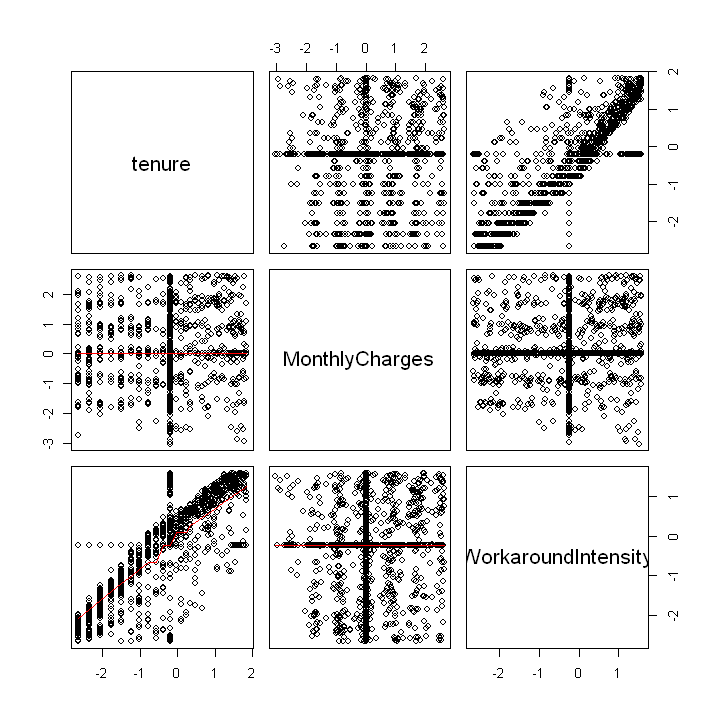

In [305]:
###---------Scatter plot
#library(corrplot)

#Resize plot
options(repr.plot.res = 120, repr.plot.height=6, repr.plot.width=6)  #Defaults:resolution=120,width/height=7

#Plot features we are interested in
pairs(data[,c("tenure","MonthlyCharges","WorkaroundIntensity")], 
      lower.panel = panel.smooth)

tenure and WorkAroundintesity might be correlated

In [306]:
#delete one column per attr to check multicoliniarity of onehot encoded data
#drop customerID column
drop=c("gender_Female", "PhoneService_No","MultipleProducts_No","InternetService_DSL","OnlineSecurity_No",
       "OnlineBackup_No","DeviceProtection_No","TechSupport_No","UsingSocial_No", "SupportMovies_No",
       "TimeUsingProduct_Month.to.month","PaperlessBilling_No", "PaymentMethod_Bank.transfer..automatic.")
var.out.bool <- !names(data) %in% drop
#simply reassign data:
data <- data[,var.out.bool, drop = FALSE]
#convert label (customerID) to numeric so it can be used by lm
data$IsLeadUser  <- as.numeric(data$IsLeadUser)

In [307]:
glimpse(data)

Observations: 3,760
Variables: 28
$ tenure                                <dbl> -0.2024013, -0.2024013, -1.24...
$ MonthlyCharges                        <dbl> 0.009170046, -1.569565315, 0....
$ WorkaroundIntensity                   <dbl> -0.23631550, -0.23631550, -0....
$ gender_Male                           <fct> 1, 0, 0, 0, 1, 0, 1, 1, 1, 1,...
$ PhoneService_Yes                      <fct> 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,...
$ MultipleProducts_No.phone.service     <fct> 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,...
$ MultipleProducts_Yes                  <fct> 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,...
$ InternetService_Fiber.optic           <fct> 0, 1, 1, 1, 1, 0, 0, 0, 1, 0,...
$ InternetService_No                    <fct> 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,...
$ OnlineSecurity_No.internet.service    <fct> 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,...
$ OnlineSecurity_Yes                    <fct> 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
$ OnlineBackup_No.internet.service      <fct> 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,...
$ OnlineBackup_Yes

In [309]:
data <- handleCollinearity(data,"IsLeadUser")


In [310]:
glimpse(data)

Observations: 3,760
Variables: 28
$ tenure                                <dbl> -0.2024013, -0.2024013, -1.24...
$ MonthlyCharges                        <dbl> 0.009170046, -1.569565315, 0....
$ WorkaroundIntensity                   <dbl> -0.23631550, -0.23631550, -0....
$ gender_Male                           <fct> 1, 0, 0, 0, 1, 0, 1, 1, 1, 1,...
$ PhoneService_Yes                      <fct> 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,...
$ MultipleProducts_No.phone.service     <fct> 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,...
$ MultipleProducts_Yes                  <fct> 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,...
$ InternetService_Fiber.optic           <fct> 0, 1, 1, 1, 1, 0, 0, 0, 1, 0,...
$ InternetService_No                    <fct> 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,...
$ OnlineSecurity_No.internet.service    <fct> 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,...
$ OnlineSecurity_Yes                    <fct> 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
$ OnlineBackup_No.internet.service      <fct> 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,...
$ OnlineBackup_Yes